<a href="https://colab.research.google.com/github/laoleks/easyMoney/blob/main/ML_pension_plan_easyMoney_Botsman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto easyMoney. Modelo de propension a la compra

##1. Resumen del proyecto

*El objetivo principal de la tarea es desarrollar un modelo de propensión a compra utilizando técnicas de machine learning. La empresa de easyMoney desea identificar qué clientes son más propensos a comprar sus productos para poder vender más y mejorar sus resultados comerciales. Se menciona que nosotros tenemos la capacidad de predecir esta información y se solicita crear el modelo utilizando técnicas apropiadas. No se especifica qué productos en particular deben ser considerados, dejando esa decisión al criterio del científico de datos. El resultado esperado es un modelo que pueda predecir la probabilidad de compra de los clientes y que pueda ser utilizado para mejorar las estrategias de venta de la empresa.*

*En este archivo, vamos a desarrollar un modelo de propensión a la compra del producto de plan de pensiones.*

##2. Importación de las bibliotecas requeridas

In [ ]:
import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from google.colab import files

In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


##3. Carga de los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

products = pd.read_csv('/content/drive/MyDrive/customer_products.csv')
sociodemographics = pd.read_csv('/content/drive/MyDrive/customer_sociodemographics.csv')
commercial = pd.read_csv('/content/drive/MyDrive/customer_commercial_activity.csv')
sales = pd.read_csv('/content/drive/MyDrive/sales.csv')
product_desc = pd.read_csv('/content/drive/MyDrive/product_description.csv')

Mounted at /content/drive


##4. Data cleaning, Joins de las tablas & Data Preparation

###Joins

*Este código elimina la columna 'Unnamed: 0' de múltiples conjuntos de datos, como products, sociodemographics, commercial, sales y product_desc. Esta columna se elimina porque no es necesaria para el análisis o modelado posterior de los datos.*

In [ ]:
def remove_unnamed_column(dataset):
    if 'Unnamed: 0' in dataset.columns:
        dataset.drop('Unnamed: 0', axis=1, inplace=True)

remove_unnamed_column(products)
remove_unnamed_column(sociodemographics)
remove_unnamed_column(commercial)
remove_unnamed_column(sales)
remove_unnamed_column(product_desc)

*Aquí se realiza la conversión de las columnas especificadas a formato de fecha y hora en varios conjuntos de datos. Mediante un bucle, se recorren los conjuntos de datos en dfs y, si las columnas están presentes, se convierten utilizando pd.to_datetime(). Esto es útil para facilitar el análisis de información temporal en las columnas 'pk_partition' y 'month_sale'.*

In [ ]:
def convert_columns_to_datetime(dfs, columns):
    for df in dfs:
        for column in columns:
            if column in df.columns:
                df[column] = pd.to_datetime(df[column])

dfs = [products, sociodemographics, commercial, sales]
columns = ['pk_partition', 'month_sale']

convert_columns_to_datetime(dfs, columns)

*El código asigna a la columna 'previous_month' en el conjunto de datos 'sales' el valor del mes anterior al de la columna 'month_sale'. Esto se realiza para poder analizar los atributos de los clientes del mes anterior al construir el modelo de propensión a la compra y combinarlo posteriormente con otras tablas de datos.*

In [ ]:
sales['previous_month'] = sales['month_sale'].dt.to_period('M') - 1
sales['previous_month'] = sales['previous_month'].dt.to_timestamp()

In [ ]:
products

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962920,1166764,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962921,1166763,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962922,1166789,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


*En este código, se seleccionan las columnas de 'products' a partir de la tercera posición y se almacenan en 'columns_products'. Luego, se utiliza pd.melt() para fundir el conjunto de datos 'products' en una estructura más conveniente llamada 'products_melted', donde las columnas 'pk_cid' y 'pk_partition' se mantienen como identificadores, y 'product_name' y 'value' se utilizan para almacenar los nombres de los productos y sus respectivos valores.*

In [ ]:
columns_products = products.columns[2:]
products_melted = pd.melt(products,id_vars=['pk_cid','pk_partition'],value_vars=columns_products,var_name='product_name',value_name='value')

In [ ]:
products_melted

,pk_cid,pk_partition,product_name,value
0,1375586,2018-01-01,short_term_deposit,0.0
1,1050611,2018-01-01,short_term_deposit,0.0
2,1050612,2018-01-01,short_term_deposit,0.0
3,1050613,2018-01-01,short_term_deposit,1.0
4,1050614,2018-01-01,short_term_deposit,0.0
...,...,...,...,...
89443855,1166765,2019-05-01,em_acount,1.0
89443856,1166764,2019-05-01,em_acount,1.0
89443857,1166763,2019-05-01,em_acount,1.0
89443858,1166789,2019-05-01,em_acount,1.0



*Aqui obtenemos un nuevo conjunto de datos que contenga únicamente las filas relacionadas con el producto llamado 'pension_plan'.*

In [ ]:
pp_melted = products_melted[products_melted['product_name'] == 'pension_plan'].copy()

In [ ]:
pp_melted

,pk_cid,pk_partition,product_name,value
53666316,1375586,2018-01-01,pension_plan,0.0
53666317,1050611,2018-01-01,pension_plan,0.0
53666318,1050612,2018-01-01,pension_plan,0.0
53666319,1050613,2018-01-01,pension_plan,0.0
53666320,1050614,2018-01-01,pension_plan,0.0
...,...,...,...,...
59629235,1166765,2019-05-01,pension_plan,0.0
59629236,1166764,2019-05-01,pension_plan,0.0
59629237,1166763,2019-05-01,pension_plan,0.0
59629238,1166789,2019-05-01,pension_plan,0.0


*En este código, se agrega información sobre el nombre del producto a la tabla 'sales'. Se crea una nueva columna llamada 'product_name' en 'sales', donde se asigna el nombre del producto correspondiente basado en la coincidencia entre los valores de 'product_ID' en 'sales' y 'pk_product_ID' en 'product_desc'. Esto permite tener el nombre del producto asociado a cada registro en la tabla 'sales'.*

In [ ]:
def merge_product_desc(sales, product_desc):
    sales['product_name'] = sales['product_ID'].map(product_desc.set_index('pk_product_ID')['product_desc'])

    return sales

sales = merge_product_desc(sales, product_desc)

In [ ]:
sales

,pk_sale,cid,month_sale,product_ID,net_margin,previous_month,product_name
0,6666,33620,2018-05-01,2335,952.9,2018-04-01,short_term_deposit
1,6667,35063,2018-06-01,2335,1625.2,2018-05-01,short_term_deposit
2,6668,37299,2018-02-01,2335,1279.7,2018-01-01,short_term_deposit
3,6669,39997,2018-02-01,2335,1511.9,2018-01-01,short_term_deposit
4,6670,44012,2018-02-01,2335,1680.3,2018-01-01,short_term_deposit
...,...,...,...,...,...,...,...
240768,247434,1553456,2019-05-01,4657,56.7,2019-04-01,em_acount
240769,247435,1553541,2019-05-01,4657,66.5,2019-04-01,em_acount
240770,247436,1553559,2019-05-01,4657,73.0,2019-04-01,em_acount
240771,247437,1553565,2019-05-01,4657,82.3,2019-04-01,em_acount


*Vamos a seleccionar únicamente las ventas del plan de pensiones.*

In [ ]:
sales_pp = sales[sales['product_name'] == 'pension_plan'].copy()

In [ ]:
sales_pp

,pk_sale,cid,month_sale,product_ID,net_margin,previous_month,product_name
34696,41362,32376,2018-03-01,1364,6285.8,2018-02-01,pension_plan
34697,41363,33205,2018-11-01,1364,6930.9,2018-10-01,pension_plan
34698,41364,35849,2019-02-01,1364,6248.8,2019-01-01,pension_plan
34699,41365,36148,2018-06-01,1364,3461.5,2018-05-01,pension_plan
34700,41366,41264,2019-04-01,1364,8696.3,2019-03-01,pension_plan
...,...,...,...,...,...,...,...
54060,60726,1551597,2019-05-01,1364,4884.9,2019-04-01,pension_plan
54061,60727,1551712,2019-05-01,1364,6028.9,2019-04-01,pension_plan
54062,60728,1551832,2019-05-01,1364,4173.2,2019-04-01,pension_plan
54063,60729,1552055,2019-05-01,1364,15543.7,2019-04-01,pension_plan



*Aquí vamos a combinar la tabla "sales" con "products_melted" del plan de pensiones.*

In [ ]:
sales_pp = pp_melted.merge(sales_pp, left_on=['pk_cid', 'pk_partition'], right_on=['cid', 'previous_month'])

In [ ]:
products_sales_pp = pp_melted.merge(sales_pp, left_on=['pk_cid', 'pk_partition'], right_on=['cid', 'previous_month'], how='left')

*Vamos a crear una nueva columna llamada "purchase" que indique si el cliente ha comprado el plan de pensiones o no.*

In [ ]:
products_sales_pp['purchase'] = products_sales_pp['pk_sale'].notnull().astype(int)

In [ ]:
products_sales_pp

,pk_cid_x,pk_partition_x,product_name,value_x,pk_cid_y,pk_partition_y,product_name_x,value_y,pk_sale,cid,month_sale,product_ID,net_margin,previous_month,product_name_y,purchase
0,1375586,2018-01-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
1,1050611,2018-01-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
2,1050612,2018-01-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
3,1050613,2018-01-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
4,1050614,2018-01-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
5962920,1166764,2019-05-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
5962921,1166763,2019-05-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0
5962922,1166789,2019-05-01,pension_plan,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0


In [ ]:
products_sales_pp.isnull().sum()

pk_cid_x                0
pk_partition_x          0
product_name            0
value_x                61
pk_cid_y          5944445
pk_partition_y    5944445
product_name_x    5944445
value_y           5944445
pk_sale           5944445
cid               5944445
month_sale        5944445
product_ID        5944445
net_margin        5944445
previous_month    5944445
product_name_y    5944445
purchase                0
dtype: int64

*Vamos a eliminar las columnas que no son necesarias para el modelo.*

In [ ]:
columns_to_drop = ['pk_cid_y', 'pk_partition_y', 'product_name_x', 'value_y', 'pk_sale', 'cid', 'month_sale', 'product_ID', 'net_margin', 'previous_month', 'product_name_y']
products_sales_pp = products_sales_pp.drop(columns_to_drop, axis=1)

*Aquí vamos a consolidar la información de los productos y las ventas del plan de pensiones para determinar qué otros tipos de productos han adquirido los clientes, ya sea que hayan realizado la compra o no.*

In [ ]:
products_sales_pp1 = products_sales_pp.merge(products, left_on=['pk_cid_x', 'pk_partition_x'], right_on=['pk_cid', 'pk_partition'])

In [ ]:
products_sales_pp1

,pk_cid_x,pk_partition_x,product_name,value_x,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,pension_plan,0.0,0,1375586,2018-01-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,pension_plan,0.0,0,1050611,2018-01-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,pension_plan,0.0,0,1050612,2018-01-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,pension_plan,0.0,0,1050613,2018-01-01,1,0,0,...,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,pension_plan,0.0,0,1050614,2018-01-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-01,pension_plan,0.0,0,1166765,2019-05-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
5962920,1166764,2019-05-01,pension_plan,0.0,0,1166764,2019-05-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
5962921,1166763,2019-05-01,pension_plan,0.0,0,1166763,2019-05-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1
5962922,1166789,2019-05-01,pension_plan,0.0,0,1166789,2019-05-01,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,1


In [ ]:
products_sales_pp1.isnull().sum()

pk_cid_x               0
pk_partition_x         0
product_name           0
value_x               61
purchase               0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

*Vemos que tenemos muchos más datos de clientes que no han realizado compras en comparación con los que sí han comprado.*

In [ ]:
products_sales_pp1['purchase'].value_counts()

0    5944445
1      18479
Name: purchase, dtype: int64

*Vamos a eliminar las columnas que no son necesarias para el modelo de nuevo.*

In [ ]:
columns_to_drop = ['pk_cid_x', 'pk_partition_x', 'product_name', 'value_x']
products_sales_pp1 = products_sales_pp1.drop(columns_to_drop, axis=1)

*Para equilibrar los datos, procederemos a seleccionar una cantidad igual de clientes que hayan realizado compras de manera aleatoria.*

In [ ]:
pp_purchase_0 = products_sales_pp1[products_sales_pp1['purchase'] == 0]

num_rows = len(pp_purchase_0)
num_samples = 18479

if num_samples >= num_rows:
    selected_rows_pp = pp_purchase_0
else:
    selected_rows_pp = pp_purchase_0.sample(n=num_samples, random_state=42)

selected_rows_pp

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
1867687,0,1328046,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1922417,0,1273949,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,0,0
5959551,0,1165094,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1871508,0,1338211,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
3754195,0,1414303,2018-12-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753142,0,1190347,2018-07-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
197699,0,1152025,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2179096,0,1273577,2018-09-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1210337,0,1203267,2018-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


*Vamos a seleccionar nuevamente a aquellos clientes que han realizado compras del plan de pensiones.*

In [ ]:
sales_pp_1 = products_sales_pp1.loc[products_sales_pp1['purchase'] == 1]

sales_pp_1

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
68,1,1050651,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,1,1,1,0,0
69,1,1050652,2018-01-01,0,0,0,0,1,0,0,0,0.0,0.0,1,1,1,0,0
157,1,1050879,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
215,1,1050911,2018-01-01,0,0,0,0,0,0,0,1,0.0,0.0,0,1,1,0,0
401,1,1050091,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517043,1,1298758,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5517407,1,1300294,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,1,0,1,0,0
5518211,1,1296566,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
5518254,1,1296383,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1


*Juntamos las dos tablas.*

In [ ]:
combined_pp = pd.concat([selected_rows_pp, sales_pp_1], axis=0)

combined_pp

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
1867687,0,1328046,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1922417,0,1273949,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,0,0
5959551,0,1165094,2019-05-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1871508,0,1338211,2018-08-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
3754195,0,1414303,2018-12-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517043,1,1298758,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5517407,1,1300294,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,1,0,1,0,0
5518211,1,1296566,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
5518254,1,1296383,2019-04-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1


*Vamos a unir también otras tablas para incorporar los atributos de los clientes en nuestro modelo de aprendizaje automático.*

In [ ]:
combined_pp = combined_pp.merge(sociodemographics, left_on=['pk_cid', 'pk_partition'], right_on=['pk_cid', 'pk_partition'])

In [ ]:
combined_pp = combined_pp.merge(commercial, left_on=['pk_cid', 'pk_partition'], right_on=['pk_cid', 'pk_partition'])

In [ ]:
combined_pp

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment
0,0,1328046,2018-08-01,0,0,0,0,0,0,0,...,ES,30.0,V,28,N,NaN,2017-10,KHE,1.0,03 - UNIVERSITARIO
1,0,1273949,2018-08-01,0,0,0,0,0,0,0,...,ES,17.0,H,56,N,362928.30,2017-07,KFC,1.0,02 - PARTICULARES
2,0,1165094,2019-05-01,0,0,0,0,0,0,0,...,ES,29.0,H,22,N,149521.59,2016-08,KHE,0.0,03 - UNIVERSITARIO
3,0,1338211,2018-08-01,0,0,0,0,0,0,0,...,ES,32.0,V,48,N,NaN,2017-10,KAT,0.0,02 - PARTICULARES
4,0,1414303,2018-12-01,0,0,0,0,0,0,0,...,ES,36.0,H,20,N,176818.11,2018-07,KHQ,1.0,03 - UNIVERSITARIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36953,1,1298758,2019-04-01,0,0,0,0,0,0,0,...,ES,46.0,V,33,N,42997.38,2017-08,KFC,1.0,03 - UNIVERSITARIO
36954,1,1300294,2019-04-01,0,0,0,0,0,0,0,...,ES,29.0,H,38,N,62834.49,2017-09,KFC,1.0,02 - PARTICULARES
36955,1,1296566,2019-04-01,0,0,0,0,0,0,0,...,ES,8.0,H,21,N,NaN,2017-08,KHE,1.0,03 - UNIVERSITARIO
36956,1,1296383,2019-04-01,0,0,0,0,0,0,0,...,ES,41.0,H,32,N,175865.82,2017-08,KAT,1.0,03 - UNIVERSITARIO


In [ ]:
combined_pp = combined_pp.drop('pension_plan', axis=1)

###Data cleaning & preprocessing

*Vamos a revisar las columnas que contienen variables no numéricas y procederemos a convertirlas en variables numéricas.*

*Vamos a verificar la cantidad de valores nulos en el nuevo conjunto de datos.*

In [ ]:
combined_pp.isnull().sum()

purchase                  0
pk_cid                    0
pk_partition              0
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
em_account_pp             0
credit_card               0
payroll                   0
payroll_account           0
emc_account               0
debit_card                0
em_account_p              0
em_acount                 0
country_id                0
region_code              14
gender                    1
age                       0
deceased                  0
salary                10158
entry_date                0
entry_channel          1984
active_customer           0
segment                2011
dtype: int64

####Salary

*Vamos a calcular el porcentaje de valores nulos en la columna "salary" de nuestro conjunto de datos.*

In [ ]:
null_percentage_salary_pp = (combined_pp['salary'].isnull().sum() / len(combined_pp['salary'])) * 100
null_percentage_salary_pp

27.48525353103523

*Hemos tomado la decisión de eliminar todos los valores nulos, ya que contamos con una cantidad suficiente de datos, y consideramos inapropiado reemplazarlos por la media o la mediana. Esto evitará proporcionar información incorrecta en nuestro conjunto de datos.*

In [ ]:
combined_pp = combined_pp.dropna(subset=['salary'])
combined_pp = combined_pp.dropna(subset=['entry_channel'])
combined_pp = combined_pp.dropna(subset=['segment'])
combined_pp = combined_pp.dropna(subset=['gender'])

####Gender

*Vamos a realizar la codificación one-hot para la variable categórica "género", dado que esta variable solamente cuenta con dos categorías.*

In [ ]:
gender_df_pp = pd.get_dummies(combined_pp['gender'], prefix='gender')
combined_pp = pd.concat([combined_pp, gender_df_pp], axis=1)

combined_pp

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,gender_H,gender_V
1,0,1273949,2018-08-01,0,0,0,0,0,0,0,...,H,56,N,362928.30,2017-07,KFC,1.0,02 - PARTICULARES,1,0
2,0,1165094,2019-05-01,0,0,0,0,0,0,0,...,H,22,N,149521.59,2016-08,KHE,0.0,03 - UNIVERSITARIO,1,0
4,0,1414303,2018-12-01,0,0,0,0,0,0,0,...,H,20,N,176818.11,2018-07,KHQ,1.0,03 - UNIVERSITARIO,1,0
6,0,1059382,2019-05-01,0,0,0,0,0,0,0,...,H,26,N,51779.82,2015-09,KHE,0.0,03 - UNIVERSITARIO,1,0
7,0,1328969,2018-11-01,0,0,0,0,0,0,0,...,H,21,N,109042.38,2017-10,KHE,0.0,03 - UNIVERSITARIO,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36952,1,1298754,2019-04-01,0,0,0,0,0,0,0,...,H,26,N,109044.12,2017-08,KFC,1.0,03 - UNIVERSITARIO,1,0
36953,1,1298758,2019-04-01,0,0,0,0,0,0,0,...,V,33,N,42997.38,2017-08,KFC,1.0,03 - UNIVERSITARIO,0,1
36954,1,1300294,2019-04-01,0,0,0,0,0,0,0,...,H,38,N,62834.49,2017-09,KFC,1.0,02 - PARTICULARES,1,0
36956,1,1296383,2019-04-01,0,0,0,0,0,0,0,...,H,32,N,175865.82,2017-08,KAT,1.0,03 - UNIVERSITARIO,1,0


In [ ]:
combined_pp = combined_pp.drop('gender', axis=1)

In [ ]:
combined_pp

,purchase,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,region_code,age,deceased,salary,entry_date,entry_channel,active_customer,segment,gender_H,gender_V
1,0,1273949,2018-08-01,0,0,0,0,0,0,0,...,17.0,56,N,362928.30,2017-07,KFC,1.0,02 - PARTICULARES,1,0
2,0,1165094,2019-05-01,0,0,0,0,0,0,0,...,29.0,22,N,149521.59,2016-08,KHE,0.0,03 - UNIVERSITARIO,1,0
4,0,1414303,2018-12-01,0,0,0,0,0,0,0,...,36.0,20,N,176818.11,2018-07,KHQ,1.0,03 - UNIVERSITARIO,1,0
6,0,1059382,2019-05-01,0,0,0,0,0,0,0,...,15.0,26,N,51779.82,2015-09,KHE,0.0,03 - UNIVERSITARIO,1,0
7,0,1328969,2018-11-01,0,0,0,0,0,0,0,...,33.0,21,N,109042.38,2017-10,KHE,0.0,03 - UNIVERSITARIO,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36952,1,1298754,2019-04-01,0,0,0,0,0,0,0,...,28.0,26,N,109044.12,2017-08,KFC,1.0,03 - UNIVERSITARIO,1,0
36953,1,1298758,2019-04-01,0,0,0,0,0,0,0,...,46.0,33,N,42997.38,2017-08,KFC,1.0,03 - UNIVERSITARIO,0,1
36954,1,1300294,2019-04-01,0,0,0,0,0,0,0,...,29.0,38,N,62834.49,2017-09,KFC,1.0,02 - PARTICULARES,1,0
36956,1,1296383,2019-04-01,0,0,0,0,0,0,0,...,41.0,32,N,175865.82,2017-08,KAT,1.0,03 - UNIVERSITARIO,1,0


####Deceased

In [ ]:
combined_pp['deceased'].value_counts()

N    26367
S        3
Name: deceased, dtype: int64

*Dado que la mayoría de los valores en la columna "deceased" son iguales, hemos decidido eliminar esta columna, ya que no influirá en nuestro modelo.*

In [ ]:
combined_pp = combined_pp.drop('deceased', axis=1)

####Country_id

In [ ]:
combined_pp['country_id'].value_counts()

ES    26370
Name: country_id, dtype: int64

*Dado que todos los clientes en la columna "country_id" son de España y solo hay un único tipo de valor, hemos decidido eliminar esta columna también, ya que no aportará información relevante a nuestro modelo.*

In [ ]:
combined_pp = combined_pp.drop('country_id', axis=1)

####Entry_date


*Vamos a cambiar el formato de fecha de la columna "entry_date" y crear una nueva variable que podría tener influencia en nuestra predicción. Esta nueva variable será la diferencia en días entre la fecha en que el cliente se registró y la fecha especificada en la columna "pk_partition", que indica si el cliente realizó o no la compra el mes siguiente.*

In [ ]:
combined_pp['entry_date'] = pd.to_datetime(combined_pp['entry_date'])

In [ ]:
combined_pp['difference_months'] = (combined_pp['pk_partition'] - combined_pp['entry_date']).dt.days // 30

combined_pp['difference_months']

1        13
2        33
4         5
6        44
7        13
         ..
36952    20
36953    20
36954    19
36956    20
36957    20
Name: difference_months, Length: 26370, dtype: int64

In [ ]:
columns_to_drop = ['pk_partition', 'entry_date']
combined_pp = combined_pp.drop(columns_to_drop, axis=1)

####Entry_channel

In [ ]:
combined_pp['entry_channel'].value_counts()

KHE    11122
KFC     5838
KAT     2585
KHK     2165
KHQ      907
KHM      906
KHN      685
RED      655
KFA      547
KHL      406
KHD      264
KHF      131
KHO       63
KHC       35
KAZ       31
KBG       11
007        6
KEH        3
KAF        2
KGC        1
KAS        1
KAJ        1
KAR        1
KBZ        1
013        1
KAE        1
KAG        1
Name: entry_channel, dtype: int64

*Vamos a eliminar las filas que contienen valores únicos en la columna "entry_channel", ya que son pocos y será mejor eliminarlos para poder realizar una transformación adecuada de esta variable categórica a numérica.*

In [ ]:
entry_channel_delete = ['KGC', 'KAS', 'KAJ', 'KAR', 'KBZ', '013', 'KAE', 'KAG']
combined_pp = combined_pp[~combined_pp['entry_channel'].isin(entry_channel_delete)]

In [ ]:
combined_pp['entry_channel'].nunique()

19

*Vamos a utilizar el codificador de objetivo (target encoder) para transformar la variable categórica en una variable numérica. Este método asignará a cada categoría un valor numérico basado en la relación entre la variable objetivo y la categoría en cuestión.*

In [ ]:
from category_encoders import TargetEncoder

codificador = TargetEncoder()
combined_pp['entry_channel_media_target'] = codificador.fit_transform(combined_pp['entry_channel'], combined_pp['purchase'])

In [ ]:
combined_pp['entry_channel_media_target'].nunique()

19

In [ ]:
combined_pp

,purchase,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,region_code,age,salary,entry_channel,active_customer,segment,gender_H,gender_V,difference_months,entry_channel_media_target
1,0,1273949,0,0,0,0,0,0,0,0,...,17.0,56,362928.30,KFC,1.0,02 - PARTICULARES,1,0,13,0.610140
2,0,1165094,0,0,0,0,0,0,0,0,...,29.0,22,149521.59,KHE,0.0,03 - UNIVERSITARIO,1,0,33,0.290955
4,0,1414303,0,0,0,0,0,0,0,0,...,36.0,20,176818.11,KHQ,1.0,03 - UNIVERSITARIO,1,0,5,0.188534
6,0,1059382,0,0,0,0,0,0,0,0,...,15.0,26,51779.82,KHE,0.0,03 - UNIVERSITARIO,1,0,44,0.290955
7,0,1328969,0,0,0,0,0,0,0,0,...,33.0,21,109042.38,KHE,0.0,03 - UNIVERSITARIO,1,0,13,0.290955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36952,1,1298754,0,0,0,0,0,0,0,0,...,28.0,26,109044.12,KFC,1.0,03 - UNIVERSITARIO,1,0,20,0.610140
36953,1,1298758,0,0,0,0,0,0,0,0,...,46.0,33,42997.38,KFC,1.0,03 - UNIVERSITARIO,0,1,20,0.610140
36954,1,1300294,0,0,0,0,0,0,0,0,...,29.0,38,62834.49,KFC,1.0,02 - PARTICULARES,1,0,19,0.610140
36956,1,1296383,0,0,0,0,0,0,0,0,...,41.0,32,175865.82,KAT,1.0,03 - UNIVERSITARIO,1,0,20,0.588781


In [ ]:
combined_pp = combined_pp.drop('entry_channel', axis=1)

####Region_code

*Vamos a reemplazar la variable categórica por el valor promedio de la variable objetivo para cada categoría. Esto implica asignar a cada categoría el valor medio de la variable objetivo correspondiente a dicha categoría.*

In [ ]:
region_media_target_pp = combined_pp.groupby('region_code')['purchase'].mean().to_frame().reset_index()
region_media_target_pp.columns = ['region_code', 'region_media_target']
region_media_target_pp

,region_code,region_media_target
0,2.0,0.370787
1,3.0,0.570439
2,4.0,0.576471
3,5.0,0.517647
4,6.0,0.275773
5,7.0,0.570755
6,8.0,0.445438
7,9.0,0.510373
8,10.0,0.297386
9,11.0,0.434269


In [ ]:
region_media_target_pp.nunique()

region_code            50
region_media_target    50
dtype: int64

In [ ]:
combined_pp = combined_pp.merge(region_media_target_pp, on='region_code', how='left')

In [ ]:
combined_pp = combined_pp.drop('region_code', axis=1)

####Segment

*Aplicaremos el mismo enfoque para la variable "segment", es decir, reemplazaremos la variable categórica por el valor promedio de la variable objetivo para cada categoría en la columna "segment". De esta manera, asignaremos a cada categoría el valor medio de la variable objetivo asociada a esa categoría.*

In [ ]:
segment_media_target_pp = combined_pp.groupby('segment')['purchase'].mean().to_frame().reset_index()
segment_media_target_pp.columns = ['segment', 'segment_media_target']
segment_media_target_pp

,segment,segment_media_target
0,01 - TOP,0.393564
1,02 - PARTICULARES,0.636198
2,03 - UNIVERSITARIO,0.363970


In [ ]:
combined_pp = combined_pp.merge(segment_media_target_pp, on='segment', how='left')

In [ ]:
combined_pp = combined_pp.drop('segment', axis=1)

###Correlaciones

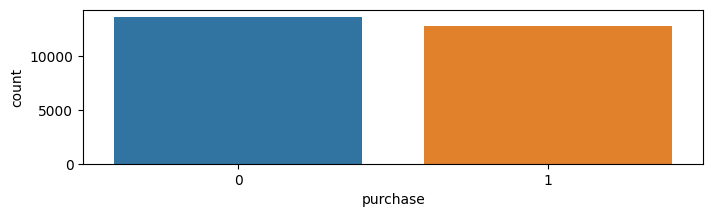

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=combined_pp, x='purchase')
plt.show()

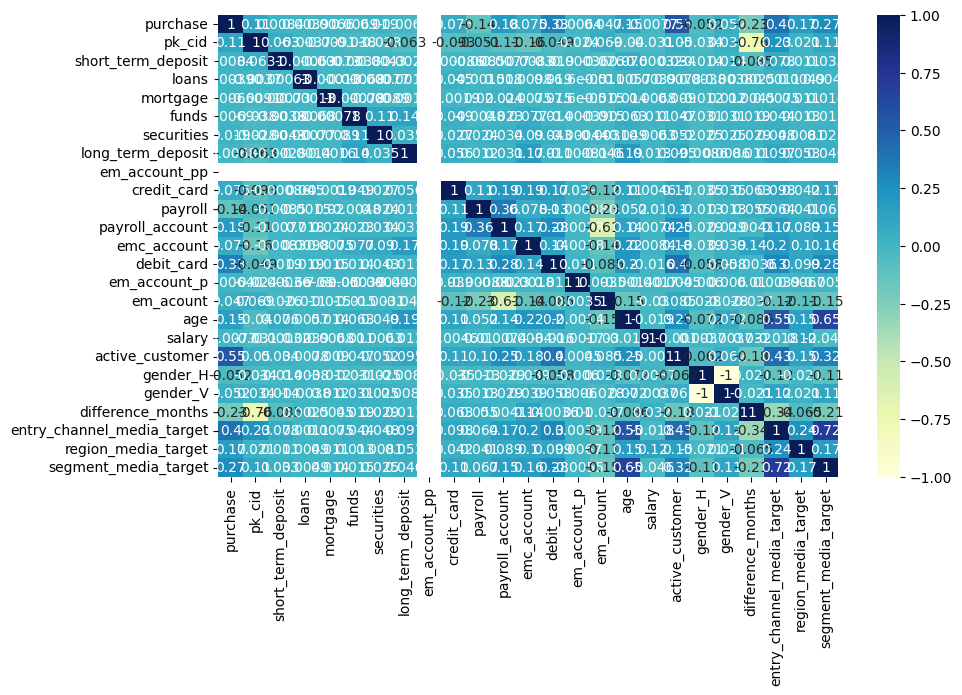

In [ ]:
plt.rcParams['figure.figsize'] = 10, 6
sns.heatmap(combined_pp.corr(), annot=True, cmap="YlGnBu")
plt.show()

###Dataset para el modelo final

*Vamos a eliminar la columna del ID del cliente del conjunto de datos principal, pero la guardaremos en un dataframe separado para poder ajustarla posteriormente una vez que realicemos la predicción.*

In [ ]:
combined_pp_ML = combined_pp.drop('pk_cid', axis=1)

In [ ]:
pk_cid = combined_pp['pk_cid']

In [ ]:
combined_pp_ML

,purchase,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,...,em_acount,age,salary,active_customer,gender_H,gender_V,difference_months,entry_channel_media_target,region_media_target,segment_media_target
0,0,0,0,0,0,0,0,0,0,0.0,...,0,56,362928.30,1.0,1,0,13,0.610140,0.421053,0.636198
1,0,0,0,0,0,0,0,0,0,0.0,...,1,22,149521.59,0.0,1,0,33,0.290955,0.465859,0.363970
2,0,0,0,0,0,0,0,0,0,0.0,...,1,20,176818.11,1.0,1,0,5,0.188534,0.345018,0.363970
3,0,0,0,0,0,0,0,0,0,0.0,...,1,26,51779.82,0.0,1,0,44,0.290955,0.352518,0.363970
4,0,0,0,0,0,0,0,0,0,0.0,...,1,21,109042.38,0.0,1,0,13,0.290955,0.439922,0.363970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26357,1,0,0,0,0,0,0,0,0,0.0,...,1,26,109044.12,1.0,1,0,20,0.610140,0.575994,0.363970
26358,1,0,0,0,0,0,0,0,0,0.0,...,1,33,42997.38,1.0,0,1,20,0.610140,0.490338,0.363970
26359,1,0,0,0,0,0,0,0,0,0.0,...,0,38,62834.49,1.0,1,0,19,0.610140,0.465859,0.636198
26360,1,0,0,0,0,0,0,0,0,0.0,...,1,32,175865.82,1.0,1,0,20,0.588781,0.501810,0.363970


In [ ]:
y = combined_pp_ML['purchase']
X = combined_pp_ML.drop('purchase', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(18453, 23)

##Machine Learning

###Logistic Regression

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_lr = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_lr)
print("Classification Report:\n", report)

Accuracy: 0.6079150335061323
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64      4099
           1       0.61      0.53      0.56      3810

    accuracy                           0.61      7909
   macro avg       0.61      0.61      0.60      7909
weighted avg       0.61      0.61      0.61      7909



###Random Forest

In [ ]:
model = RandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", report)

Accuracy: 0.8124920976103174
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81      4099
           1       0.79      0.84      0.81      3810

    accuracy                           0.81      7909
   macro avg       0.81      0.81      0.81      7909
weighted avg       0.81      0.81      0.81      7909



###XGBClassifier

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", report)

Accuracy: 0.8167909975976735
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      4099
           1       0.79      0.85      0.82      3810

    accuracy                           0.82      7909
   macro avg       0.82      0.82      0.82      7909
weighted avg       0.82      0.82      0.82      7909



###Support Vector Machines (SVM)

In [ ]:
model = SVC()

In [ ]:
model.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_svc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_svc)
print("Classification Report:\n", report)

Accuracy: 0.5170059425970414
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68      4099
           1       0.42      0.01      0.01      3810

    accuracy                           0.52      7909
   macro avg       0.47      0.50      0.35      7909
weighted avg       0.47      0.52      0.36      7909



###Gradient Boosting Classifier

In [ ]:
model = GradientBoostingClassifier()

In [ ]:
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_gb = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_gb)
print("Classification Report:\n", report)

Accuracy: 0.8218485269945631
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82      4099
           1       0.78      0.88      0.83      3810

    accuracy                           0.82      7909
   macro avg       0.83      0.82      0.82      7909
weighted avg       0.83      0.82      0.82      7909



###Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("Accuracy:", accuracy_dt)
print("Classification Report:\n", report)

Accuracy: 0.7273991655076495
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      4099
           1       0.72      0.71      0.71      3810

    accuracy                           0.73      7909
   macro avg       0.73      0.73      0.73      7909
weighted avg       0.73      0.73      0.73      7909



###Resumen de accuracy

In [ ]:
accuracy_df = pd.DataFrame({'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb, accuracy_svc, accuracy_gb, accuracy_dt]}, index=['Logistic Regression', 'Random Forest', 'XGBClassifier', 'SVC', 'Gradient Boosting', 'Decision Tree'])

In [ ]:
accuracy_df = accuracy_df.sort_values('Accuracy')
accuracy_df

,Accuracy
SVC,0.517006
Logistic Regression,0.607915
Decision Tree,0.727399
Random Forest,0.812492
XGBClassifier,0.816791
Gradient Boosting,0.821849


###GridSearchCV

In [ ]:
#param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5],

}

In [ ]:
#model = GradientBoostingClassifier()

In [ ]:
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5], 'max_leaf_nodes': [None, 2, 3],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 1]})

In [ ]:
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

In [ ]:
#accuracy = accuracy_score(y_test, y_pred)
#report = classification_report(y_test, y_pred)

In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': None, 'n_estimators': 100, 'subsample': 0.7}
Accuracy: 0.822860032873941
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      4099
           1       0.79      0.87      0.83      3810

    accuracy                           0.82      7909
   macro avg       0.83      0.82      0.82      7909
weighted avg       0.83      0.82      0.82      7909



##Eleccion del modelo

In [ ]:
model = GradientBoostingClassifier()

In [ ]:
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
predictions = model.predict(X)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC:", roc_auc)

ROC AUC: 0.7266645920296801


In [ ]:
probabilities = (model.predict_proba(X)[:, 1] * 100).round().astype(int)

In [ ]:
result_pp = pd.DataFrame({'pk_cid': pk_cid, 'prediction': predictions, 'probability': probabilities})

In [ ]:
result_pp

,pk_cid,prediction,probability
0,1273949,0,44
1,1165094,0,9
2,1414303,0,16
3,1059382,0,6
4,1328969,0,7
...,...,...,...
26357,1298754,1,73
26358,1298758,1,72
26359,1300294,1,89
26360,1296383,1,84


In [ ]:
result_pp.to_csv('result_pp.csv', index=False)
files.download('result_pp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result_pp['prediction'].value_counts()

1    14355
0    12007
Name: prediction, dtype: int64

In [ ]:
combined_pp['purchase'].value_counts()

0    13616
1    12746
Name: purchase, dtype: int64

In [ ]:
scores = cross_val_score(model, X, y, cv=5)

print("Cross-Validation Scores:", scores)
print("Mean CV Score:", scores.mean())

Cross-Validation Scores: [0.84714584 0.83671534 0.80652504 0.78205615 0.71623672]
Mean CV Score: 0.7977358171024433
